## 3. Exploratory Data Analysis

### Import Libraries

In [ ]:
import pandas as pd
from scipy.stats import boxcox

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# Load data
df2 = pd.read_csv(r'datasets\player_dataset_clean.csv')
df2.head()

,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,LM,RB,RM,ST,Card Type,Acceleration Type,Work Rate (Attack),Work Rate (Defense),Height (cm),Weight (kg)
0,98,4020000.0,5,4,95,96,93,96,60,76,...,0,0,0,1,icon,explosive,h,m,173.0,70.0
1,98,5000000.0,4,4,93,98,97,99,40,77,...,0,0,1,0,toty,controlled,h,l,169.0,67.0
2,97,2310000.0,4,5,92,97,90,94,45,90,...,0,0,0,1,toty,controlled,h,m,185.0,81.0
3,97,11200000.0,5,4,99,96,88,98,44,87,...,0,0,0,1,toty,controlled,h,l,182.0,73.0
4,97,2580000.0,4,5,85,94,98,94,81,86,...,0,0,0,0,toty,controlled,h,h,181.0,70.0


### Replacing NaN values

First I will look to see if there are any NaN values in the dataset:

In [ ]:
df2.isna().sum().sort_values(ascending=False).head()

Card Type    673
Rating         0
LM             0
CM             0
LB             0
dtype: int64

In [ ]:
# Since Card Type has some NaN values, I will look into the value counts to see which are the most popular values
df2['Card Type'].value_counts().head()

Card Type
normal          14054
non-rare         1077
rare              666
libertadores      502
if                485
Name: count, dtype: int64

In [ ]:
# Since 'normal' is by far the most common, I will opt to replace all NaN values with this value
df2['Card Type'] = df2['Card Type'].fillna('normal')

In [ ]:
# Now I rerun this code to check that all NaN values have been ammended 
df2.isna().sum().sort_values(ascending=False).head()

Rating    0
RWB       0
CM        0
LB        0
GK        0
dtype: int64

### Target Variable Analysis

We will now look into our target variable Price. For this stage we will split out data into a train and test sets and only do anaylysis on the training set in order to avoid any data leakage. 


In [ ]:
# Train Test Split
df_train, df_test = train_test_split(
    df2, test_size=0.3, random_state=42
)

# Save datasets
df_train.to_csv(r'datasets\train_dataset.csv', index=False)
df_test.to_csv(r'datasets\test_dataset.csv', index=False)

Skew value of Price = 29.08


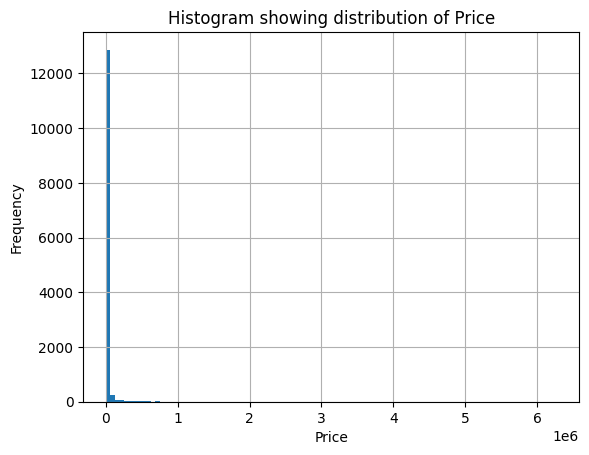

In [ ]:
df_train.Price.hist(bins=100)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram showing distribution of Price');
print(f'Skew value of Price = {df.Price.skew():.2f}')

We can see here that the Price column is heavily skewed. This makes sense as the rarer players in the game are generally the most sought after and therefore are worth the most. We can see below that a significant proportion of these are players priced at below 1000 coins:

In [ ]:
# Number of players at each price point below 1000
below_5000_counts = df_train[df_train['Price']<5000]['Price'].value_counts().head(20)
print(below_5000_counts.head(10))
below_5000_proportion = (below_5000_counts.sum()/df_train.shape[0])*100
print('\n')
print(f'{below_5000_proportion:.2f}% of all entries are below 5000 coins')

Price
400.0     3735
200.0     3502
450.0      731
500.0      335
350.0      278
850.0      227
1000.0     216
900.0      204
550.0      201
600.0      180
Name: count, dtype: int64


81.13% of all entries are below 5000 coins


Realistically, anything below 5000 coins is a small amount of money in the game and can be easily afforded by most gamers. The model should allow users to identify value in the marketplace so this model would be better built to predict higher valued players. Therefore, I will look into ways to reduce the dataset so that a significant propotion of these lower-valued players are removed. 

Generally players with a higher Rating are worth the most in the game so we can look into whether removing lower rated players can help us reduce the lower-valued players in the dataset:

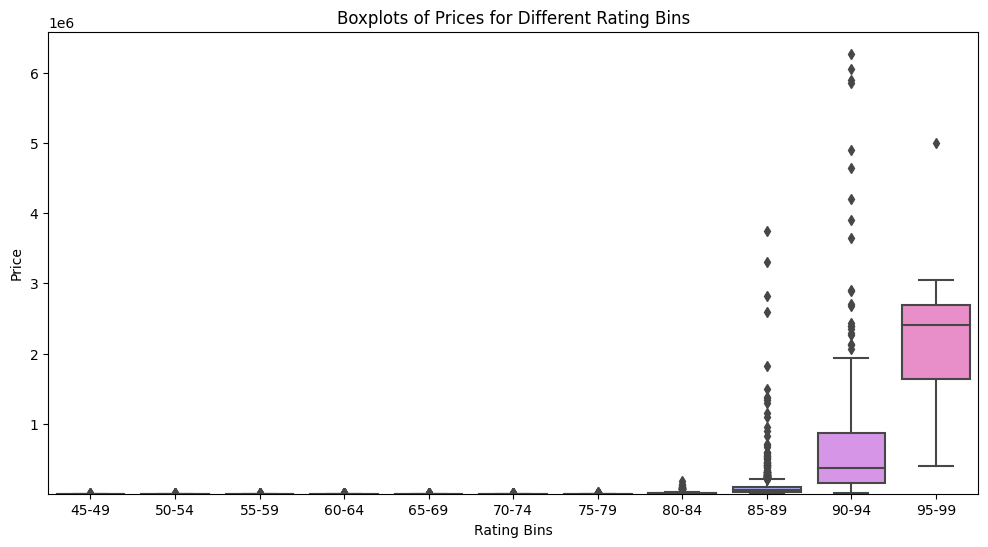

In [ ]:
# Create bins for the Rating column
bins = range(45, 105, 5)
labels = [f'{i}-{i+4}' for i in range(45,96,5)]
df_train_bins= pd.cut(df_train["Rating"], bins=bins, labels=labels)

# Create boxplots for Price for each of these bins
fig, ax = plt.subplots(figsize = (12,6))

sns.boxplot(x=df_train_bins, y=df_train['Price'], ax=ax)

ax.set_xlabel('Rating Bins')
ax.set_ylabel('Price')
ax.set_ylim(5000)
ax.set_title('Boxplots of Prices for Different Rating Bins');

From the above graph we can see that we definitely want to include all players with a Rating over 90 in our model. However, we can also look deeper into the players with a rating below 90 to see if it's worth keeping any of these in our dataset. 

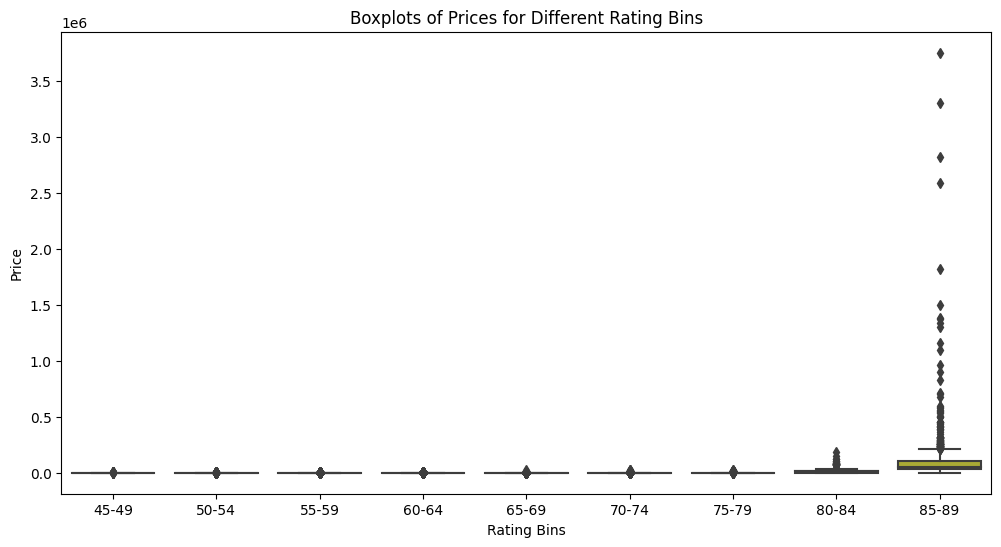

In [ ]:
# Create bins for the Rating column
bins = range(45, 95, 5)
labels = [f'{i}-{i+4}' for i in range(45,86,5)]
df_train_bins= pd.cut(df_train["Rating"], bins=bins, labels=labels)

# Create boxplots for Price for each of these bins
fig, ax = plt.subplots(figsize = (12,6))

sns.boxplot(x=df_train_bins, y=df_train['Price'], ax=ax)

ax.set_xlabel('Rating Bins')
ax.set_ylabel('Price')
ax.set_title('Boxplots of Prices for Different Rating Bins');

In [ ]:
# We can also see the number of player priced over 5000 for each bin
num_players_over_5000 = df_train[df_train['Price'] > 5000].groupby(df_train_bins)['Price'].count()
print(num_players_over_5000)

Rating
45-49      7
50-54     19
55-59     40
60-64     80
65-69     44
70-74     29
75-79     72
80-84    337
85-89    703
Name: Price, dtype: int64


We can look into the Card Type for players that are rated below 85 as generally special edition cards are worth more:

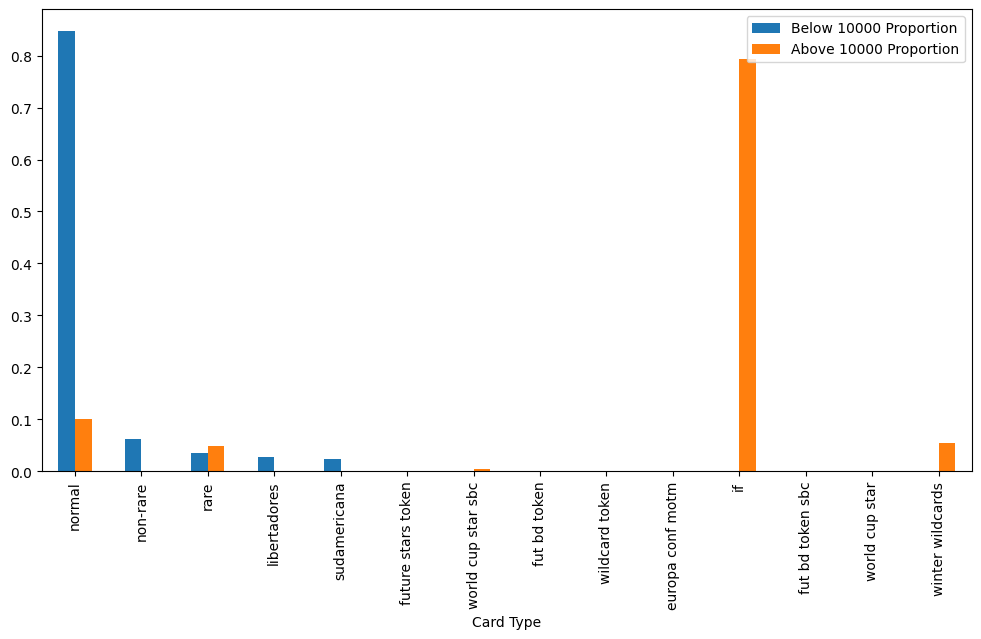

In [ ]:
# Create new dataframes for players rated below 80 for both over and under 1000 coins
df_below85_above10000 = df_train[(df_train['Rating'] < 90) & (df_train['Price'] > 10000)]
df_below85_below10000 = df_train[(df_train['Rating'] < 90) & (df_train['Price'] < 10000)]

# Creare additional new dataframes counting the different Card Types for both of the above dataframes
df_below85_above10000_count = pd.DataFrame(df_below85_above10000['Card Type'].value_counts()).reset_index()
df_below85_below10000_count = pd.DataFrame(df_below85_below10000['Card Type'].value_counts()).reset_index()

# Merge the dataframes on Card Type and rename the columns 
card_types = df_below85_above10000_count.merge(df_below85_below10000_count, how='right', on='Card Type')
card_types.rename({'count_x' : 'Above 10000 Count', 'count_y' : 'Below 10000 Count'}, axis=1, inplace=True)

# Fill NaN values with 0 and create new columns for the proportions 
card_types.fillna(0, inplace=True)
card_types['Above 10000 Proportion'] = card_types['Above 10000 Count'].apply(lambda x: x/card_types['Above 10000 Count'].sum())
card_types['Below 10000 Proportion'] = card_types['Below 10000 Count'].apply(lambda x: x/card_types['Below 10000 Count'].sum())

# Plot in a bar graph
fig, ax = plt.subplots(figsize = (12,6))
card_types.plot(x='Card Type', y = ['Below 10000 Proportion', 'Above 10000 Proportion'], kind='bar', ax=ax)
plt.legend(loc='upper right');

Based on the information presented in the graph, it would be prudent to exclude 'normal', 'non-rare', 'libertadores' and 'sudamerica' cards from the dataset, as they represent a disproportionately higher proportion of cards that are valued at less than 10000 coins.

To simplify the analysis, we will also exclude 'rare' cards, since these, along with the aforementioned types, are the only non-special cards. As such, our model will focus on predicting the value of player cards with a rating of 90 or higher, as well as special cards with a rating below 90.

Since we are redefining the purpose of the model, we will remove these values from both the train and test dataset:

In [ ]:
df_train2 = df_train[(df_train['Rating'] >= 90) | ~(df_train['Card Type'].isin(['normal', 'non-rare', 'rare', 'libertadores','sudamericana']))]
df_test2 = df_test[(df_test['Rating'] >= 90) | ~(df_test['Card Type'].isin(['normal', 'non-rare', 'rare', 'libertadores','sudamericana']))]

print('Old number of rows:', (df_train.shape[0] + df_test.shape[0]))
print('New number of rows:', (df_train2.shape[0] + df_test2.shape[0]))
print('\n')
print('Old skew value of Price column:', df_train['Price'].skew().round(2))
print('New skew value of Price column:', df_train2['Price'].skew().round(2))

# Save datasets
df_train2.to_csv(r'datasets\train_dataset.csv', index=False)
df_test2.to_csv(r'datasets\test_dataset.csv', index=False)

Old number of rows: 19159
New number of rows: 1780


Old skew value of Price column: 19.12
New skew value of Price column: 5.92


Our target column for our training dataset is still heavily skewed so we will remove some outliers. However, we will only remove these from the training dataset to avoid data leakage:

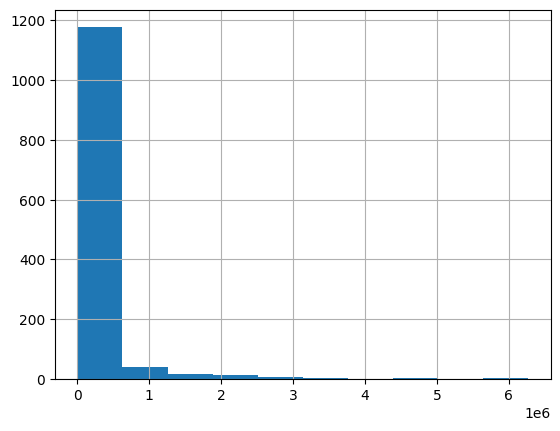

In [ ]:
# Plot a histogram
df_train2.Price.hist();

In [ ]:
# Overwrite the saved dataset
df_train2.to_csv(r'datasets\train_dataset.csv', index=False)

### Categorical Feature Analysis

Now we will do some analysis into the categorical columns:

In [ ]:
# Load data
df_train = pd.read_csv(r'datasets\train_dataset.csv')
df_test = pd.read_csv(r'datasets\test_dataset.csv')

In [ ]:
cat_df = df_train.select_dtypes(include='object')
cat_df.head()

,Team,Nation,League,Card Type,Acceleration Type,Work Rate (Attack),Work Rate (Defense)
0,zagłębie lubin,bosnia and herzegovina,polski ekstraklasa (pol 1),if,controlled,m,m
1,rcd espanyol,spain,laliga santander,sif,lengthy,h,m
2,ajax,netherlands,eredivisie,if,controlled,m,m
3,rennes,belgium,ligue 1,if,explosive,h,m
4,fut icons,france,icons,icon,controlled,m,m


First I will look into the Work Rate columns:

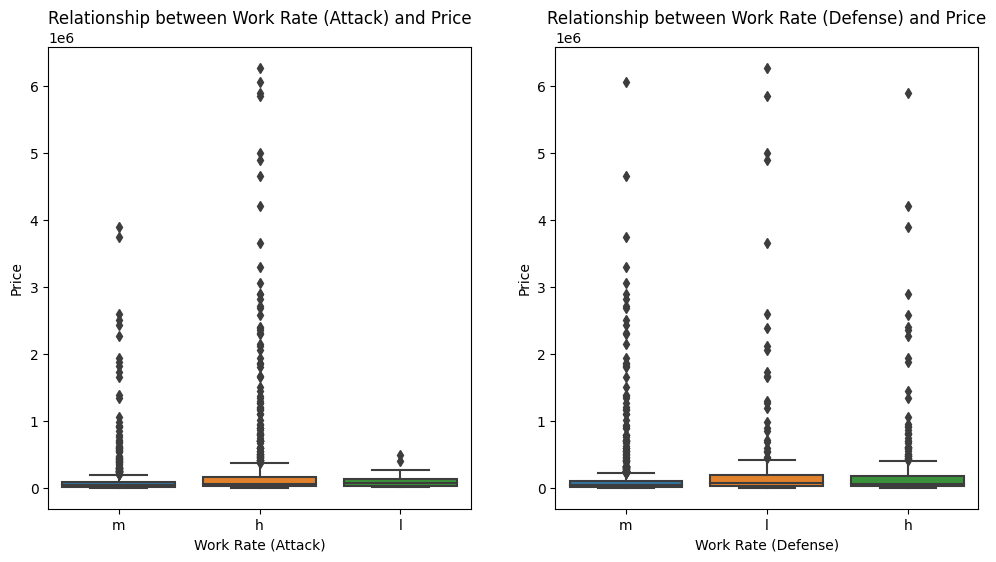

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

sns.boxplot(x='Work Rate (Attack)', y='Price', data=df_train, ax=ax1)
ax1.set_xlabel('Work Rate (Attack)')
ax1.set_ylabel('Price')
ax1.set(title='Relationship between Work Rate (Attack) and Price')

sns.boxplot(x='Work Rate (Defense)', y='Price', data=df_train, ax=ax2)
ax2.set_xlabel('Work Rate (Defense)')
ax2.set(title='Relationship between Work Rate (Defense) and Price');

Although our target variable Price is still fairly heavily skewed, there seems to be a clear correlation with 'Work Rate (Attack)' and 'Price' but not so much with 'Work Rate (Defense)' and 'Price'. However, since we can ordinal encode this columns, we will keep both for now as we won't be adding any additional columns:

In [ ]:
# Create encoder object
encoder = OrdinalEncoder(categories=[['l', 'm', 'h']], handle_unknown='use_encoded_value', unknown_value=4)

# Fit and transorm on train data and transform test data - Attack
df_train['WR_Att_OE'] = encoder.fit_transform(df_train[['Work Rate (Attack)']])
df_test['WR_Att_OE'] = encoder.fit_transform(df_test[['Work Rate (Attack)']])

# Fit and transorm on train data and transform test data - Defense
df_train['WR_Def_OE'] = encoder.fit_transform(df_train[['Work Rate (Defense)']])
df_test['WR_Def_OE'] = encoder.fit_transform(df_test[['Work Rate (Defense)']])

# Drop original columns
df_train.drop(['Work Rate (Attack)', 'Work Rate (Defense)'], axis=1, inplace=True)
df_test.drop(['Work Rate (Attack)', 'Work Rate (Defense)'], axis=1, inplace=True)


In [ ]:
cat_df = df_train.select_dtypes(include='object')
cat_df.head()

,Team,Nation,League,Card Type,Acceleration Type
0,zagłębie lubin,bosnia and herzegovina,polski ekstraklasa (pol 1),if,controlled
1,rcd espanyol,spain,laliga santander,sif,lengthy
2,ajax,netherlands,eredivisie,if,controlled
3,rennes,belgium,ligue 1,if,explosive
4,fut icons,france,icons,icon,controlled


Next we will look into 'Acceleration Type':

In [ ]:
df_train['Acceleration Type'].value_counts()

Acceleration Type
controlled    726
explosive     299
lengthy       242
Name: count, dtype: int64

Since there are only three different values here, it will be fine to one-hot encode these without adding too many new columns

We will create a function that one-hot-encodes our feature, adds the columns onto the original dataset, and deletes the orginal feature

In [ ]:
def add_ohe_columns(df_train, df_test, column):
    
    # Create OHE object
    ohe = OneHotEncoder(handle_unknown='ignore')

    # Fit and transform train data
    ohe.fit(df_train[[column]])
    ohe_cols_train = ohe.transform(df_train[[column]])
    ohe_df_train = pd.DataFrame(ohe_cols_train.toarray(), columns=ohe.get_feature_names_out())

    # Concatenate with orgiginal dataframe and drop old column
    new_df_train = pd.concat([df_train, ohe_df_train], axis=1)
    new_df_train.drop(column, axis=1, inplace=True)

    # Transform test data
    ohe_cols_test = ohe.transform(df_test[[column]])
    ohe_df_test = pd.DataFrame(ohe_cols_test.toarray(), columns=ohe.get_feature_names_out())

    # Concatenate with orgiginal dataframe and drop old column
    new_df_test = pd.concat([df_test, ohe_df_test], axis=1)
    new_df_test.drop(column, axis=1, inplace=True)

    # Return new dataframe
    return new_df_train, new_df_test


In [ ]:
df_train

,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,LM,RB,RM,ST,Card Type,Acceleration Type,Height (cm),Weight (kg),WR_Att_OE,WR_Def_OE
0,79,11750.0,1,2,79,79,75,79,41,80,...,0,0,0,0,if,controlled,193.0,72.794708,1.0,1.0
1,86,19750.0,3,3,70,87,76,82,38,81,...,0,0,0,1,sif,lengthy,192.0,72.794708,2.0,1.0
2,81,16250.0,1,4,80,83,88,83,49,82,...,0,0,0,0,if,controlled,187.0,72.794708,1.0,1.0
3,83,11000.0,4,3,95,75,76,88,35,74,...,0,0,1,0,if,explosive,171.0,60.000000,2.0,1.0
4,93,670000.0,4,4,94,91,83,90,53,80,...,0,0,0,1,icon,controlled,188.0,72.794708,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,85,75000.0,3,4,91,86,66,79,40,74,...,0,0,0,1,icon,controlled,175.0,72.000000,1.0,1.0
1263,91,469000.0,3,4,87,84,86,77,89,82,...,0,0,1,0,icon,controlled,174.0,70.000000,2.0,2.0
1264,88,35500.0,3,4,83,88,78,80,40,84,...,0,0,0,1,if,lengthy,191.0,94.000000,1.0,0.0
1265,83,12500.0,2,3,67,51,68,73,83,90,...,0,0,0,0,if,lengthy,190.0,72.794708,1.0,2.0


In [ ]:
# OHE 'Acceleration Type
df_train, df_test = add_ohe_columns(df_train, df_test, 'Acceleration Type')

# Check to see columns have successfully been encoded
display(df_train.head(2))
display(df_test.head(2))

,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,RM,ST,Card Type,Height (cm),Weight (kg),WR_Att_OE,WR_Def_OE,Acceleration Type_controlled,Acceleration Type_explosive,Acceleration Type_lengthy
0,79,11750.0,1,2,79,79,75,79,41,80,...,0,0,if,193.0,72.794708,1.0,1.0,1.0,0.0,0.0
1,86,19750.0,3,3,70,87,76,82,38,81,...,0,1,sif,192.0,72.794708,2.0,1.0,0.0,0.0,1.0


,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,RM,ST,Card Type,Height (cm),Weight (kg),WR_Att_OE,WR_Def_OE,Acceleration Type_controlled,Acceleration Type_explosive,Acceleration Type_lengthy
0,90,120000.0,1,3,88,87,80,90,53,91,...,0,0,world cup icon,196.0,72.794708,1.0,1.0,1.0,0.0,0.0
1,87,26500.0,4,3,80,80,87,90,49,72,...,0,0,if,180.0,81.000000,2.0,1.0,1.0,0.0,0.0


In [ ]:
df_train.columns

Index(['Rating', 'Price', 'Skills', 'Weak Foot', 'Pace', 'Shooting', 'Passing',
       'Dribbling', 'Defending', 'Physicality', 'Popularity', 'Base Stats',
       'In Game Stats', 'Team', 'Nation', 'League', 'CB', 'RW', 'LW', 'RWB',
       'LWB', 'CM', 'LB', 'GK', 'CAM', 'CF', 'CDM', 'LM', 'RB', 'RM', 'ST',
       'Card Type', 'Height (cm)', 'Weight (kg)', 'WR_Att_OE', 'WR_Def_OE',
       'Acceleration Type_controlled', 'Acceleration Type_explosive',
       'Acceleration Type_lengthy'],
      dtype='object')

In [ ]:
cat_df = df_train.select_dtypes(include='object')
cat_df.head()

,Team,Nation,League,Card Type
0,zagłębie lubin,bosnia and herzegovina,polski ekstraklasa (pol 1),if
1,rcd espanyol,spain,laliga santander,sif
2,ajax,netherlands,eredivisie,if
3,rennes,belgium,ligue 1,if
4,fut icons,france,icons,icon


Next we look into the Card Type column. Since there are a lot of values in this column we will find ways to group some of them together.

In [ ]:
# Show number of unique values
print('Number of unique Card Type values:', df_train['Card Type'].nunique())

Number of unique Card Type values: 80


In [ ]:
# Return a list of Card Type values
df_train['Card Type'].value_counts().index

Index(['if', 'icon', 'sif', 'hero', 'fut future stars', 'winter wildcards',
       'fut centurions', 'fut birthday', 'world cup ptg', 'world cup icon',
       'fantasy', 'normal', 'trophy titans - icon', 'world cup hero',
       'showdown sbc', 'world cup phenoms', 'world cup showdown s',
       'world cup stories', 'world cup tott', 'flashback sbc', 'rulebreakers',
       'fantasy hero', 'motm', 'road to world cup', 'dynamic duos',
       'world cup star sbc', 'ucl live', 'toty', 'fut birthday sbc',
       'future stars token', 'winter wildcards sbc', 'fut bd token', 'otw',
       'toty honourable ment', 'tif', 'champions league', 'out of position',
       'toty icon', 'trophy titans hero', 'fut ballers sbc',
       'player moments sbc', 'potm serie a sbc', 'out of position sbc',
       'fut centurions sbc', 'uel live', 'pl potm sbc', 'wildcard token',
       'fut future stars sbc', 'eredivisie potm sbc', 'ligue 1 potm sbc',
       'cl motm', 'laliga potm sbc', 'otw sbc', 'europa leag

First we can create a function for replacing values containing certain strings with another value:

In [ ]:
def replace_cat_values(df_train, df_test, column, old_values, new_value):
    
    # Create copies of the dataframes 
    new_df_train = df_train.copy()
    new_df_test = df_test.copy()

    # Convert old_values to a string, if it is a list, for use in str.contains()
    if type(old_values) == str:
        string = old_values
    elif type(old_values) == list:
        string = '|'.join(old_values)
        
    # Create a mask of rows where the column contains any of the old values
    train_mask = new_df_train[column].str.contains(string)
    test_mask = new_df_test[column].str.contains(string)

    # Replace the old values with the new value in the selected rows
    new_df_train.loc[train_mask, column] = new_value
    new_df_test.loc[test_mask, column] = new_value

    # Return new df
    return new_df_train, new_df_test



We can group all SBC, MOTM, Icon, Hero, Token and IF cards: 

In [ ]:
# SBC (We use 'sb' as one value is missing the 'c')
df_train, df_test = replace_cat_values(df_train, df_test, 'Card Type', 'sb', 'sbc')

# MOTM
df_train, df_test = replace_cat_values(df_train, df_test, 'Card Type', 'motm', 'motm')

# Icon
df_train, df_test = replace_cat_values(df_train, df_test, 'Card Type', 'icon', 'icon')

# Hero
df_train, df_test = replace_cat_values(df_train, df_test, 'Card Type', 'hero', 'hero')

# Token
df_train, df_test = replace_cat_values(df_train, df_test, 'Card Type', 'token', 'token')

# IF
df_train, df_test = replace_cat_values(df_train, df_test, 'Card Type', 'if', 'if')

# Show updated number of unique values
print('Number of unique Card Type values:', df_train['Card Type'].nunique())
# Return an updated list of Card Type values
df_train['Card Type'].value_counts().index

Number of unique Card Type values: 33


Index(['if', 'icon', 'sbc', 'hero', 'fut future stars', 'winter wildcards',
       'fut centurions', 'fut birthday', 'world cup ptg', 'fantasy', 'motm',
       'token', 'normal', 'world cup showdown s', 'world cup phenoms',
       'rulebreakers', 'world cup stories', 'world cup tott', 'ucl live',
       'dynamic duos', 'road to world cup', 'toty', 'champions league', 'otw',
       'out of position', 'toty honourable ment', 'uel live',
       'conference league', 'world cup showdown', 'world cup star',
       'uecl live', 'europa league', 'rare'],
      dtype='object', name='Card Type')

Next we'll group all the tournament cards together:

In [ ]:
# World Cup
df_train, df_test = replace_cat_values(df_train, df_test, 'Card Type', 'world cup', 'world cup')

# UEFA Cup competitions
df_train, df_test = replace_cat_values(df_train, df_test, 'Card Type', ['ucl','uel','uecl','champions league','europa league','conference league'], 'uefa cup comps')

# South America competitions
df_train, df_test = replace_cat_values(df_train, df_test, 'Card Type', ['sudamericana','libertadores'], 'south america comps')

# Show updated number of unique values
print('Number of unique Card Type values:', df_train['Card Type'].nunique())
# Return an updated list of Card Type values
df_train['Card Type'].value_counts().index

Number of unique Card Type values: 21


Index(['if', 'icon', 'sbc', 'world cup', 'hero', 'fut future stars',
       'winter wildcards', 'fut centurions', 'uefa cup comps', 'fut birthday',
       'fantasy', 'token', 'motm', 'normal', 'rulebreakers', 'dynamic duos',
       'toty', 'toty honourable ment', 'out of position', 'otw', 'rare'],
      dtype='object', name='Card Type')

We can also group Normal, Rare and Non-Rare cards together as these generally all the non-special cards in the game:

In [ ]:
df_train, df_test = replace_cat_values(df_train, df_test, 'Card Type', ['normal','rare','non-rare'], 'non-special')

# Show updated number of unique values
print('Number of unique Card Type values:', df_train['Card Type'].nunique())
# Return an updated list of Card Type values
df_train['Card Type'].value_counts().index

Number of unique Card Type values: 20


Index(['if', 'icon', 'sbc', 'world cup', 'hero', 'fut future stars',
       'winter wildcards', 'fut centurions', 'uefa cup comps', 'fut birthday',
       'fantasy', 'non-special', 'motm', 'token', 'rulebreakers',
       'dynamic duos', 'toty', 'otw', 'out of position',
       'toty honourable ment'],
      dtype='object', name='Card Type')

We will now look into the median Price values of the new Card Type values:  

In [ ]:
df_train.groupby('Card Type')['Price'].median().sort_values(ascending=False)

Card Type
toty                    2095000.0
non-special              304000.0
toty honourable ment     157000.0
icon                     115000.0
fut future stars          79500.0
sbc                       74950.0
fut birthday              74000.0
uefa cup comps            63500.0
world cup                 58000.0
hero                      58000.0
fantasy                   53500.0
winter wildcards          40375.0
otw                       40250.0
fut centurions            34500.0
rulebreakers              31375.0
dynamic duos              29150.0
out of position           28000.0
motm                      17500.0
if                        16500.0
token                      3550.0
Name: Price, dtype: float64

We can see above that apart from TOTY and TOTY Honourable Mention, all the other card types are on a similar scale, therefore we will create an 'Other' category for the remaining types that weren't grouped earlier: 

In [ ]:
# Get a list of card types not already grouped
all_types = df_train['Card Type'].value_counts().index.to_list()
replaced_types = ['icon', 'south america comps', 'sbc', 'uefa cup comps', 'world cup', 'hero', 'motm', 'if']
to_replace_types = [type for type in all_types if type not in replaced_types]

# Replace these with 'other'
df_train, df_test = replace_cat_values(df_train, df_test, 'Card Type', to_replace_types, 'other') 

# Show updated number of unique values
print('Number of unique Card Type values:', df_train['Card Type'].nunique())
# Return an updated list of Card Type values
df_train['Card Type'].value_counts().index

Number of unique Card Type values: 8


Index(['if', 'icon', 'other', 'sbc', 'world cup', 'hero', 'uefa cup comps',
       'motm'],
      dtype='object', name='Card Type')

Now that we just have significantly reduced our unique values for this feature, we can one-hot-encode it without adding too many additional features.

In [ ]:
# OHE 'Acceleration Type
df_train, df_test = add_ohe_columns(df_train, df_test, 'Card Type')

# Check to see columns have successfully been encoded
display(df_train.head(2))
display(df_test.head(2))

,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,Acceleration Type_explosive,Acceleration Type_lengthy,Card Type_hero,Card Type_icon,Card Type_if,Card Type_motm,Card Type_other,Card Type_sbc,Card Type_uefa cup comps,Card Type_world cup
0,79,11750.0,1,2,79,79,75,79,41,80,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,86,19750.0,3,3,70,87,76,82,38,81,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,Acceleration Type_explosive,Acceleration Type_lengthy,Card Type_hero,Card Type_icon,Card Type_if,Card Type_motm,Card Type_other,Card Type_sbc,Card Type_uefa cup comps,Card Type_world cup
0,90,120000.0,1,3,88,87,80,90,53,91,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,87,26500.0,4,3,80,80,87,90,49,72,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
cat_df = df_train.select_dtypes(include='object')
cat_df.head()

,Team,Nation,League
0,zagłębie lubin,bosnia and herzegovina,polski ekstraklasa (pol 1)
1,rcd espanyol,spain,laliga santander
2,ajax,netherlands,eredivisie
3,rennes,belgium,ligue 1
4,fut icons,france,icons


We will now look into the League column:

In [ ]:
# Show number of unique values
print('Number of unique League values:', df_train['League'].nunique())

# Return an updated list of League values
league_names = df_train['League'].value_counts().index
print(league_names)

Number of unique League values: 44
Index(['icons', 'premier league', 'serie a tim', 'laliga santander',
       'bundesliga', 'ligue 1', 'major league soccer', 'eredivisie',
       'liga nos (por 1)', 'süper lig (tur 1)', 'efl championship (eng 2)',
       '1a pro league (bel 1)', 'mbs pro league (sau 1)',
       'scottish premiership (spfl)', '3. liga (ger 3)',
       'efl league two (eng 4)', 'bundesliga 2 (ger 2)',
       'raiffeisen super l. (sui 1)', 'a-league (aus 1)', 'world cup',
       'ligue 2 (fra 2)', 'allsvenskan (swe 1)', 'italy serie b (2)',
       'indian super league (ind 1)', 'primera división (arg 1)',
       'polski ekstraklasa (pol 1)', 'laliga smartbank (esp 2)',
       'efl league one (eng 3)', 'ö bundesliga (aut 1)',
       '3f superliga (den 1)', 'ukrayina liha (ukr 1)', 'česká liga (cze 1)',
       'liga i (rom 1)', 'south african fl (rsa 1)', 'hellas liga (gre 1)',
       'liga hrvatska (cro 1)', 'conmebol libertadores',
       'chinese fa super l. (chn 1)', '

We will keep all the big 5 European leagues as their own columns as well as MLS and special categories such as Icons and World Cup. For the rest we will group by division and continent. 

In [ ]:
# Big 5 league's lower divisions:
big5_low_divs = [league[:league.find('(')] for league in league_names if league[-2] in ['2','3','4','5']]
df_train, df_test = replace_cat_values(df_train, df_test, 'League', big5_low_divs, 'big5_low_div')

# South American Divisions:
df_train, df_test = replace_cat_values(df_train, df_test, 'League', ['conmebol libertadores', 'conmebol sudamericana', 'primera división (arg 1)'], 'sa_leagues')

# Asian and Australian Divisions:
df_train, df_test = replace_cat_values(df_train, df_test, 'League', ['a-league (aus 1)', 'indian super league (ind 1)', 'chinese fa super l. (chn 1)','k league 1 (kor 1)'], 'asia_aus_leagues')

# Middle Eastern Leagues:
df_train, df_test = replace_cat_values(df_train, df_test, 'League', ['united emirates l. (uae 1)', 'mbs pro league (sau 1)'], 'me_leagues')

# Remaining European Leagues:
rem_eur_divs = [league[:league.find('(')] for league in league_names if league[-2] in ['1','l']]
df_train, df_test = replace_cat_values(df_train, df_test, 'League', rem_eur_divs, 'rem_eur_div')

# Show number of unique values
print('Number of unique League values:', df_train['League'].nunique())

# Return an updated list of League values
league_names = df_train['League'].value_counts().index
print(league_names)

Number of unique League values: 12
Index(['icons', 'premier league', 'serie a tim', 'laliga santander',
       'rem_eur_div', 'bundesliga', 'ligue 1', 'big5_low_div',
       'major league soccer', 'eredivisie', 'world cup', 'sa_leagues'],
      dtype='object', name='League')


Now that we have significantly reduced the unique values, we can encode the columns:

In [ ]:
# OHE 'Acceleration Type
df_train, df_test = add_ohe_columns(df_train, df_test, 'League')

# Check to see columns have successfully been encoded
display(df_train.head(2))
display(df_test.head(2))

,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,League_eredivisie,League_icons,League_laliga santander,League_ligue 1,League_major league soccer,League_premier league,League_rem_eur_div,League_sa_leagues,League_serie a tim,League_world cup
0,79,11750.0,1,2,79,79,75,79,41,80,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,86,19750.0,3,3,70,87,76,82,38,81,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,League_eredivisie,League_icons,League_laliga santander,League_ligue 1,League_major league soccer,League_premier league,League_rem_eur_div,League_sa_leagues,League_serie a tim,League_world cup
0,90,120000.0,1,3,88,87,80,90,53,91,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,87,26500.0,4,3,80,80,87,90,49,72,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Next we will group all the player nationalities in the Nation column as the continent of each nation:

In [ ]:
# Show number of unique values
print('Number of unique Nation values:', df_train['Nation'].nunique())

# Return an updated list of League values
nation_names = df_train['Nation'].value_counts().index
print(nation_names)

Number of unique Nation values: 86
Index(['france', 'england', 'spain', 'germany', 'brazil', 'netherlands',
       'italy', 'argentina', 'portugal', 'belgium', 'uruguay', 'croatia',
       'denmark', 'mexico', 'côte d'ivoire', 'serbia', 'united states',
       'australia', 'nigeria', 'scotland', 'norway', 'sweden', 'austria',
       'wales', 'senegal', 'ghana', 'japan', 'cameroon', 'poland', 'morocco',
       'republic of ireland', 'switzerland', 'colombia', 'korea republic',
       'ukraine', 'canada', 'algeria', 'saudi arabia', 'hungary',
       'bosnia and herzegovina', 'ecuador', 'georgia', 'czech republic',
       'romania', 'congo dr', 'finland', 'egypt', 'northern ireland',
       'tunisia', 'russia', 'turkey', 'burkina faso', 'paraguay', 'gabon',
       'iceland', 'new zealand', 'kosovo', 'slovenia', 'mali', 'jamaica',
       'greece', 'costa rica', 'benin', 'chile', 'mozambique', 'qatar',
       'bulgaria', 'south africa', 'latvia', 'faroe islands', 'india', 'togo',
       'bu

In [ ]:
# We can define a function to convert a country to its continent

import pycountry_convert as pc

def country_to_continent(country_name):
    try:
        # Convert the country name to its corresponding ISO alpha-2 code
        country_alpha2 = pc.country_name_to_country_alpha2(country_name.title())
        # Use the alpha-2 code to determine the continent code
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        # Convert the continent code to its corresponding continent name
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except LookupError:
        # If the country name is not found in the pycountry database, return "Unknown"
        return country_name


In [ ]:
# We create a new column callled 'Continent' usinf the above function
df_train['Continent'] = df_train['Nation'].apply(lambda x: country_to_continent(x))
df_test['Continent'] = df_test['Nation'].apply(lambda x: country_to_continent(x))

# Show number of unique values
print('Number of unique Continent values:', df_train['Continent'].nunique())

# Return an updated list of League values
continent_names = df_train['Continent'].value_counts().index
print(continent_names)

Number of unique Continent values: 18
Index(['Europe', 'South America', 'england', 'Africa', 'North America', 'Asia',
       'côte d'ivoire', 'Oceania', 'scotland', 'wales', 'republic of ireland',
       'korea republic', 'bosnia and herzegovina', 'congo dr',
       'northern ireland', 'kosovo', 'china pr', 'antigua and barbuda'],
      dtype='object', name='Continent')


We can now manually change the countries that the function didn't work on: 

In [ ]:
# Europe:
df_train, df_test = replace_cat_values(df_train, df_test, 'Continent',
                          ['england', 'scotland', 'northern ireland','republic of ireland', 'wales', 'bosnia and herzegovina','kosovo', 'fyr macedonia'],
                          'Europe')

# Africa:
df_train, df_test = replace_cat_values(df_train, df_test, 'Continent', ["côte d'ivoire",'congo dr'], 'Africa')

# Asia:
df_train, df_test = replace_cat_values(df_train, df_test, 'Continent', ['korea republic','china pr'], 'Asia')

# North America:
df_train, df_test = replace_cat_values(df_train, df_test, 'Continent', ['trinidad and tobago' ,'antigua and barbuda'], 'North America')

# Show number of unique values
print('Number of unique Continent values:', df_train['Continent'].nunique())

# Return an updated list of League values
continent_names = df_train['Continent'].value_counts().index
print(continent_names)

Number of unique Continent values: 6
Index(['Europe', 'South America', 'Africa', 'North America', 'Asia',
       'Oceania'],
      dtype='object', name='Continent')


Now we can drop the Nation column and encode the Continent columns:

In [ ]:
# Drop Nation columns:
df_train.drop('Nation', axis=1, inplace=True)
df_test.drop('Nation', axis=1, inplace=True)

# OHE Continent column
df_train, df_test = add_ohe_columns(df_train, df_test, 'Continent')

# Check to see columns have successfully been encoded
display(df_train.head(2))
display(df_test.head(2))

,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,League_rem_eur_div,League_sa_leagues,League_serie a tim,League_world cup,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America
0,79,11750.0,1,2,79,79,75,79,41,80,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,86,19750.0,3,3,70,87,76,82,38,81,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,League_rem_eur_div,League_sa_leagues,League_serie a tim,League_world cup,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America
0,90,120000.0,1,3,88,87,80,90,53,91,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,87,26500.0,4,3,80,80,87,90,49,72,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Finally we can look into encoding the Team column: 

In [ ]:
# Show number of unique values
print('Number of unique Team values:', df_train['Team'].nunique())

# Return an updated list of League values
team_names = df_train['Team'].value_counts().index
print(team_names)

Number of unique Team values: 248
Index(['fut icons', 'hero', 'manchester utd', 'manchester city', 'fc bayern',
       'milan', 'chelsea', 'fc barcelona', 'liverpool', 'dortmund',
       ...
       'talleres', 'wrexham afc', 'dynamo kyiv', 'fsv zwickau', 'st. pats',
       'brazil', 'panathinaikos', 'rsc anderlecht', 'charlotte fc',
       'damac fc'],
      dtype='object', name='Team', length=248)


For this we will group all but the biggest teams into an 'Other' category and then encode:

In [ ]:
# We can retrieve a list of the 20 teams with the most players
top_teams = df_train['Team'].value_counts().head(20).index.to_list()

# We can then use this to get a list of the other teams
other_teams = [team for team in team_names if team not in top_teams]

# Replace the other teams with 'Other'
df_train['Team'] = df_train['Team'].replace({team : 'Other' for team in other_teams})
df_test['Team'] = df_test['Team'].replace({team : 'Other' for team in other_teams})

In [ ]:
# Show number of unique values
print('Number of unique Team values:', df_train['Team'].nunique())

# Return an updated list of League values
team_names = df_train['Team'].value_counts().index
print(team_names)

Number of unique Team values: 21
Index(['Other', 'fut icons', 'hero', 'manchester utd', 'fc bayern',
       'manchester city', 'milan', 'chelsea', 'fc barcelona', 'liverpool',
       'dortmund', 'napoli', 'paris sg', 'real madrid', 'arsenal',
       'atlético de madrid', 'juventus', 'rb leipzig', 'spurs', 'inter',
       'sevilla fc'],
      dtype='object', name='Team')


In [ ]:
# OHE Team column
df_train, df_test = add_ohe_columns(df_train, df_test, 'Team')

# Check to see columns have successfully been encoded
display(df_train.head(2))
display(df_test.head(2))

,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,Team_liverpool,Team_manchester city,Team_manchester utd,Team_milan,Team_napoli,Team_paris sg,Team_rb leipzig,Team_real madrid,Team_sevilla fc,Team_spurs
0,79,11750.0,1,2,79,79,75,79,41,80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,86,19750.0,3,3,70,87,76,82,38,81,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,Team_liverpool,Team_manchester city,Team_manchester utd,Team_milan,Team_napoli,Team_paris sg,Team_rb leipzig,Team_real madrid,Team_sevilla fc,Team_spurs
0,90,120000.0,1,3,88,87,80,90,53,91,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,87,26500.0,4,3,80,80,87,90,49,72,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Overwrite saved files
df_train.to_csv(r'datasets\train_dataset.csv', index=False)
df_test.to_csv(r'datasets\test_dataset.csv', index=False)

### Analysis of numerical features

In [ ]:
# Load dataframes
df_train = pd.read_csv(r'datasets\train_dataset.csv')
df_test = pd.read_csv(r'datasets\test_dataset.csv')

In [ ]:
# Retrieve the position column names
pos_df = pd.read_csv(r'datasets\unique_positions.csv')
unique_positions = list(pos_df['0'].values)

encoded_cols = [col for col in df_train.columns if '_' in col]

# We can create a new dataframe that drops our encoded features
num_df_train = df_train.select_dtypes(exclude='bool').drop(encoded_cols + unique_positions, axis=1)
num_df_test = df_test.select_dtypes(exclude='bool').drop(encoded_cols + unique_positions, axis=1)

num_df_train.head()

,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,Popularity,Base Stats,In Game Stats,Height (cm),Weight (kg)
0,79,11750.0,1,2,79,79,75,79,41,80,21,433,802,193.0,72.794708
1,86,19750.0,3,3,70,87,76,82,38,81,46,434,2091,192.0,72.794708
2,81,16250.0,1,4,80,83,88,83,49,82,106,465,976,187.0,72.794708
3,83,11000.0,4,3,95,75,76,88,35,74,66,443,2057,171.0,60.000000
4,93,670000.0,4,4,94,91,83,90,53,80,1240,491,2332,188.0,72.794708


We'll first look at the distributions of the features to spot anything of note:

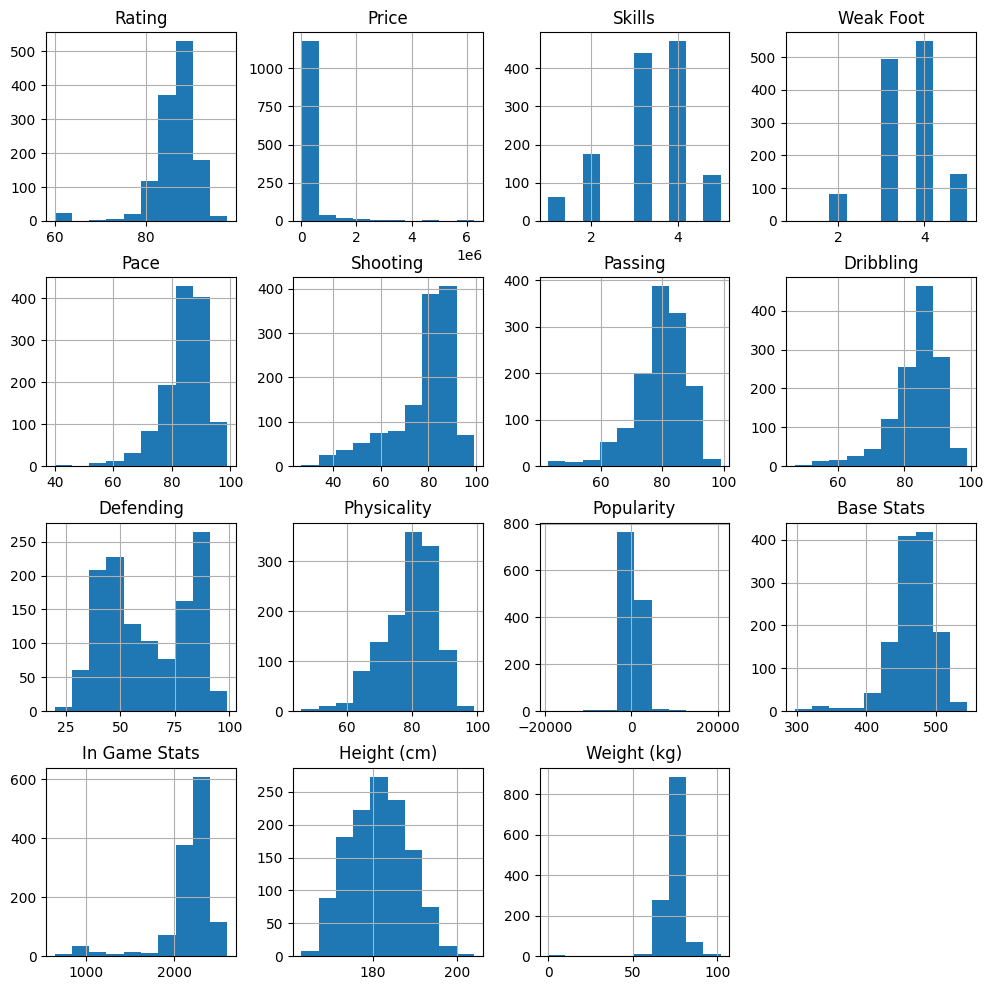

In [ ]:
fig, ax = plt.subplots(figsize = (12,12))

num_df_train.hist(ax=ax);

We can see that many of our features are heavily skewed so we will need to fix this. There seems to be an issue with the Weight column containing small values which we will look into:  We also know that popularity should be our only feature with negative values, and this appears to be the case above which is good, but we can check for sure:

In [ ]:
# Show minimum weight value
print('Minimum weight value (Train):', num_df_train['Weight (kg)'].min())
print('Minimum weight value (Test):', num_df_test['Weight (kg)'].min())

Minimum weight value (Train): 0.0
Minimum weight value (Test): 59.0


This is clearly an error so we can replace with the mean:

In [ ]:
# Replace zero values with the mean:
num_df_train['Weight (kg)'] = num_df_train['Weight (kg)'].replace({0: num_df_train['Weight (kg)'].mean()})

# Show new minimum weight value
print('Minimum weight value:', num_df_train['Weight (kg)'].min())

Minimum weight value: 58.0


This new minimum seems more logical. We can also sense check the max Weight as well as the min and max Heights:

In [ ]:
# Show maximum weight values
print('Maximum weight value (Train):', num_df_train['Weight (kg)'].max())
print('Maximum weight value (Test):', num_df_test['Weight (kg)'].max())
print('\n')

# Show minimum height values
print('Minimum height value (Train):', num_df_train['Height (cm)'].min())
print('Minimum height value (Test):', num_df_test['Height (cm)'].min())
print('\n')

# Show maximum height values
print('Maximum height value (Train):', num_df_train['Height (cm)'].max())
print('Maximum height value (Test):', num_df_test['Height (cm)'].max())
print('\n')

Maximum weight value (Train): 102.0
Maximum weight value (Test): 94.0


Minimum height value (Train): 163.0
Minimum height value (Test): 166.0


Maximum height value (Train): 204.0
Maximum height value (Test): 201.0




We also know that many of these features must be capped at 100, so we will make sure none of the features with values over 100 are the ones that should be capped: 

In [ ]:
# Get a list of all columns with values over 100:
over100_cols_train = num_df_train.columns[(num_df_train > 100).any()].to_list()
over100_cols_test = num_df_test.columns[(num_df_test > 100).any()].to_list()

print('Columns with values over 100 (Train):', over100_cols_train)
print('Columns with values over 100 (Test):', over100_cols_test)

Columns with values over 100 (Train): ['Price', 'Popularity', 'Base Stats', 'In Game Stats', 'Height (cm)', 'Weight (kg)']
Columns with values over 100 (Test): ['Price', 'Popularity', 'Base Stats', 'In Game Stats', 'Height (cm)']


The above columns are all fine to have values over 100 so there is no issue there.

We will now look into the Popularity feature which we can see has most of the values concentrated around 0:

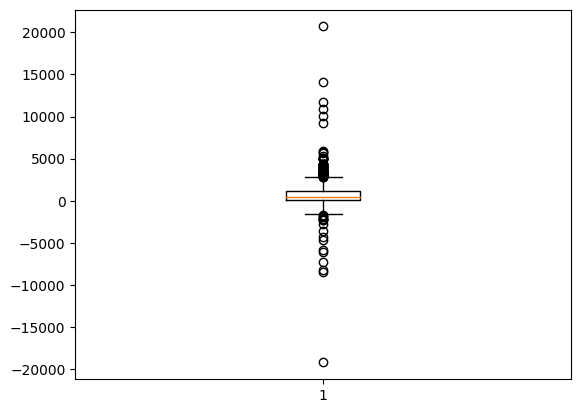

In [ ]:
plt.boxplot(num_df_train.Popularity);

Therefore, for this feature it may be best to split it into bins:

In [ ]:
# Define the bin edges
bin_edges = [-float('inf'), -1000, -100, -10, 0, 10, 100, 1000, float('inf')]

# Bin the 'Popularity' column using the cut method
num_df_train['Popularity'] = pd.cut(num_df_train['Popularity'], bins=bin_edges, labels=[1,2,3,4,5,6,7,8])
num_df_test['Popularity'] = pd.cut(num_df_test['Popularity'], bins=bin_edges, labels=[1,2,3,4,5,6,7,8])

# Convert to integers
num_df_train['Popularity'] = num_df_train['Popularity'].astype('int')
num_df_test['Popularity'] = num_df_test['Popularity'].astype('int')

We now look into transforming all skewed columns:

In [ ]:
# We can view the skew values for each feature
skew_vals = num_df_train.skew().sort_values(ascending=False)
print(skew_vals)

Price            5.922970
Weight (kg)      1.044725
Height (cm)      0.105181
Defending        0.074959
Weak Foot       -0.021454
Skills          -0.405772
Physicality     -0.797045
Passing         -1.143437
Shooting        -1.395138
Pace            -1.413325
Base Stats      -1.420017
Dribbling       -1.497740
Popularity      -1.931044
Rating          -2.378422
In Game Stats   -2.683087
dtype: float64


In [ ]:
# We define a skew limit 
skew_limit = 0.75

# We get a list of all the columns with a skew value over this limit
skew_cols = skew_vals[abs(skew_vals) > skew_limit].index.to_list()
print(skew_cols)

['Price', 'Weight (kg)', 'Physicality', 'Passing', 'Shooting', 'Pace', 'Base Stats', 'Dribbling', 'Popularity', 'Rating', 'In Game Stats']


We can then apply a BoxCox transformation to each skewed feature over this limit. However we will first have to add a constant onto Popularity to ensure the values are all positive:

In [ ]:
# Box-Cox transform the features:
for feature in skew_cols:
    if feature == 'Price':
        continue

    # apply Box-Cox transformation to training set
    transformed_train, lam = boxcox(num_df_train[feature])
    num_df_train[feature] = pd.Series(transformed_train)
    
    # apply same transformation to test set
    transformed_test = boxcox(num_df_test[feature], lmbda=lam)
    num_df_test[feature] = pd.Series(transformed_test)

In [ ]:
# Check the updated skew values
skew_vals = num_df_train.skew().sort_values(ascending=False)
print(skew_vals)

Price            5.922970
Height (cm)      0.105181
Rating           0.088374
Defending        0.074959
Base Stats       0.053054
Weak Foot       -0.021454
Passing         -0.047922
Pace            -0.064779
Physicality     -0.077808
Dribbling       -0.079239
Weight (kg)     -0.079872
In Game Stats   -0.315217
Shooting        -0.339838
Skills          -0.405772
Popularity      -0.564810
dtype: float64


Now that we're happy with our numerical data, we can replace all values in the original dataframe with the updated values:

In [ ]:
# Get a list of numerical column names
num_cols = num_df_train.columns.to_list()

# Replace columns in orginal dataframes with updated columns
df_train[num_cols] = num_df_train
df_test[num_cols] = num_df_test

In [ ]:
# Overwrite saved datasets
df_train.to_csv(r'datasets\train_dataset.csv', index=False)
df_test.to_csv(r'datasets\test_dataset.csv', index=False)

Although we have significantly reduced our dataset, we should still have enough data to create a model, and this model should now perform better on higher-valued players. 